In [1]:
%run setup.ipynb
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}
rcParams['figure.dpi'] = 120

In [2]:
df_samples = phase1_ar3.df_samples
df_samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,...,pca_3L_free_pc3,pca_3L_free_pc4,pca_2La_pc1,pca_2La_pc2,pca_2La_pc3,pca_2La_pc4,pca_2Rb_pc1,pca_2Rb_pc2,pca_2Rb_pc3,pca_2Rb_pc4
index,,,,,,,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,...,-8.290940,-18.542768,-55.511389,32.682143,-1.833739,-0.381984,-38.934301,31.939383,19.345606,7.362004
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,...,-38.603076,76.915617,-51.856633,27.401249,2.586488,0.643100,-10.072879,29.007266,-21.736087,-30.309562
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,...,-35.553340,73.985488,-50.942456,28.572207,3.072583,-0.643137,12.281744,22.288417,-43.661301,-51.557140
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,...,-36.621568,76.453993,-51.169247,29.414975,2.198434,0.013562,-10.664072,29.601333,-16.831559,-25.452854
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,...,-36.097756,72.036309,-48.607416,26.407532,1.643226,0.102582,12.897113,22.194444,-48.882378,-52.420487


In [3]:
df_samples.query('country == "Kenya"').region.value_counts()

Kilifi-Mbogolo    31
Kilifi-Junju      13
Name: region, dtype: int64

In [4]:
@cache
def compute_ac(chrom, query, downsample=None, seed=42):
    
    # locate samples
    sample_ixs = df_samples.query(query).index.values.tolist()
    if downsample:
        random.seed(seed)
        sample_ixs = sorted(random.sample(sample_ixs, downsample))
    
    # setup genotypes
    callset_pass = phase1_ar31.callset_pass
    gt = allel.GenotypeDaskArray(callset_pass[chrom]['calldata/genotype'])
    
    # compute allele counts
    ac = gt.count_alleles(subpop=sample_ixs, max_allele=3).compute()
    
    # extract positions
    pos = callset_pass[chrom]['variants/POS'][:]
    
    return pos, ac


In [5]:
query_mbogolo = 'country == "Kenya" and region == "Kilifi-Mbogolo"'
query_junju = 'country == "Kenya" and region == "Kilifi-Junju"'

In [6]:
pos, ac = compute_ac('3R', query_mbogolo)
ac

<AlleleCountsArray shape=(13167162, 4) dtype=int64>
60  0  0  0
60  0  0  0
60  0  0  0
...
62  0  0  0
62  0  0  0
62  0  0  0

In [7]:
@cache
def compute_windowed_diversity(chrom, query, window_size=100000, downsample=None, seed=42):
    
    if isinstance(chrom, tuple):
        results = [compute_windowed_diversity(c, query, window_size=window_size, downsample=downsample, seed=seed) for c in chrom]
        windows = np.concatenate([r[0] for r in results], axis=0)
        pi = np.concatenate([r[1] for r in results])
        return windows, pi
    
    # get allele counts
    pos, ac = compute_ac(chrom, query, downsample=downsample, seed=seed)
    
    # load accessibility
    is_accessible = phase1_ar3.accessibility[chrom]['is_accessible'][:]
    
    # setup windows
    windows = allel.equally_accessible_windows(is_accessible, size=window_size)
    
    # run windowed computation
    pi, _, _, _ = allel.windowed_diversity(pos, ac, windows=windows, is_accessible=is_accessible)
    # convert to %
    pi = pi * 100
    
    return windows, pi
    

In [8]:
def plot_pi_comparison(chrom, window_size=100000, ax=None, downsample=None, seed=42):
    
    _, y1 = compute_windowed_diversity(chrom, query=query_mbogolo, window_size=window_size, downsample=downsample, seed=seed)
    _, y2 = compute_windowed_diversity(chrom, query=query_junju, window_size=window_size, downsample=downsample, seed=seed)
    
    # compute statistics
    ci = bootstrap.ci(y1, np.median)
    print('Mbogolo', chrom, window_size, 'pi=%.2f%%, 95%% CI [%.2f - %.2f]' % (np.median(y1), ci[0], ci[1]))
    ci = bootstrap.ci(y2, np.median)
    print('Junju', chrom, window_size, 'pi=%.2f%%, 95%% CI [%.2f - %.2f]' % (np.median(y2), ci[0], ci[1]))
    t, p = scipy.stats.wilcoxon(y1, y2)
    p_fmt = ('%.2e' % p) if p < 0.001 else ('%.3f' % p)
    print('Wilcoxon P=%s' % p_fmt)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 4))
        
    sns.violinplot(data=[y1, y2], inner='box', ax=ax, linewidth=1.5)
    
    ax.grid(axis='y')
    ax.set_xticklabels(['Mbogolo', 'Junju'])
#     ax.set_xlabel('Sampling location')
    yticks = np.arange(0, 2, .2)
    ax.set_yticks(yticks)
#     ax.set_yticklabels(['%.1f' % v for v in yticks])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_ylabel('Nucleotide diversity (%)')
    ax.text(.5, .95, 'P = %s' % p_fmt, transform=ax.transAxes, ha='center', va='top', fontsize=base_font_size)
    if isinstance(chrom, tuple):
        ax.set_title('Chromosomes %s' % ', '.join(chrom))
    else:
        ax.set_title('Chromosome %s' % str(chrom))
    

Mbogolo ('3R', '3L', '2R', '2L') 100000 pi=0.84%, 95% CI [0.83 - 0.86]
Junju ('3R', '3L', '2R', '2L') 100000 pi=0.89%, 95% CI [0.88 - 0.90]
Wilcoxon P=1.32e-35


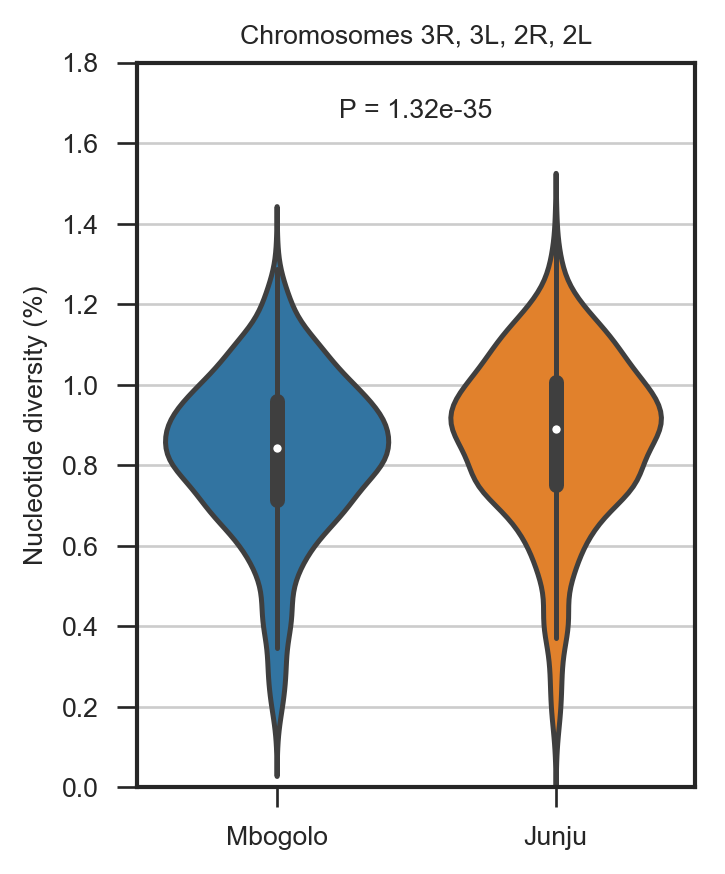

In [9]:
fig, ax = plt.subplots(figsize=(3, 4))
plot_pi_comparison(('3R', '3L', '2R', '2L'), window_size=100000, ax=ax)
fig.savefig('../artwork/pi_comparison_autosomes.png', dpi=150, bbox_inches='tight')

Mbogolo X 100000 pi=0.45%, 95% CI [0.42 - 0.47]
Junju X 100000 pi=0.45%, 95% CI [0.43 - 0.48]
Wilcoxon P=0.260


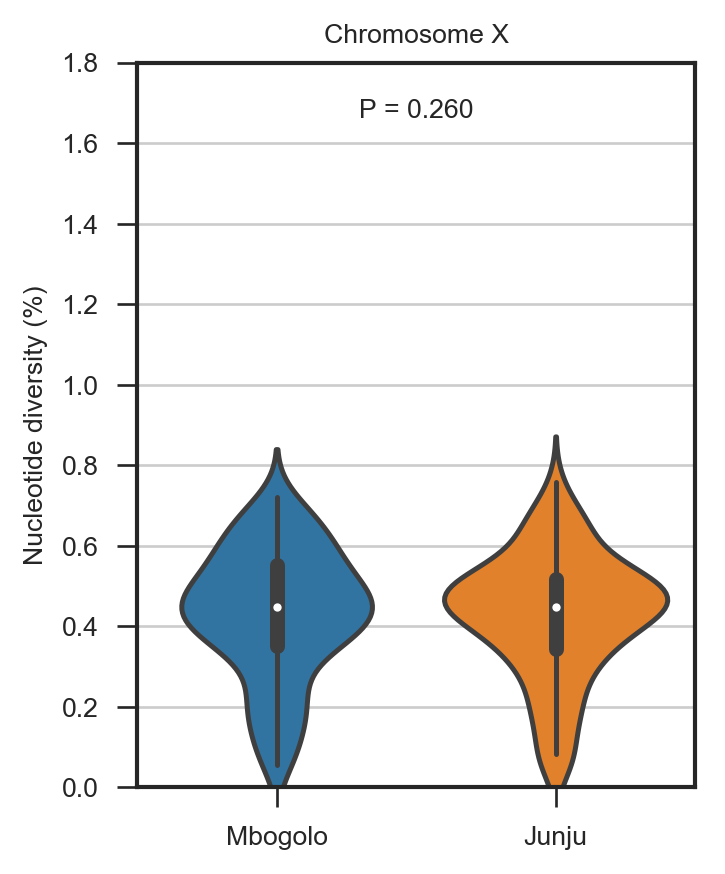

In [10]:
fig, ax = plt.subplots(figsize=(3, 4))
plot_pi_comparison('X', window_size=100000, ax=ax)
fig.savefig('../artwork/pi_comparison_X.png', dpi=150, bbox_inches='tight')

Mbogolo 3R 100000 pi=0.76%, 95% CI [0.74 - 0.80]
Junju 3R 100000 pi=0.90%, 95% CI [0.87 - 0.93]
Wilcoxon P=3.24e-22


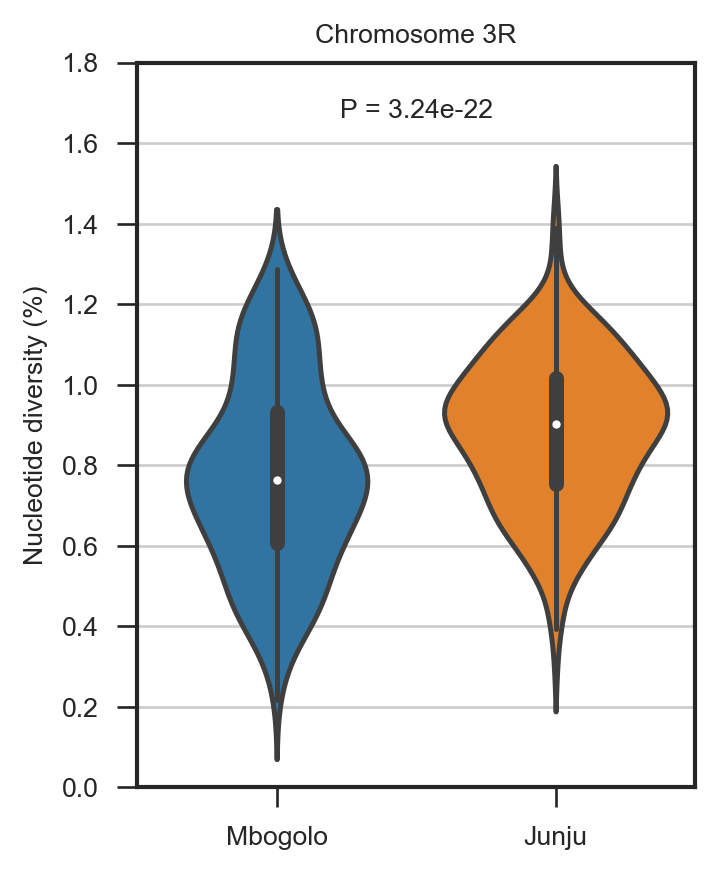

In [11]:
plot_pi_comparison('3R', window_size=100000, downsample=13, seed=1)

Mbogolo 3R 100000 pi=0.84%, 95% CI [0.80 - 0.87]
Junju 3R 100000 pi=0.90%, 95% CI [0.87 - 0.93]
Wilcoxon P=1.70e-05


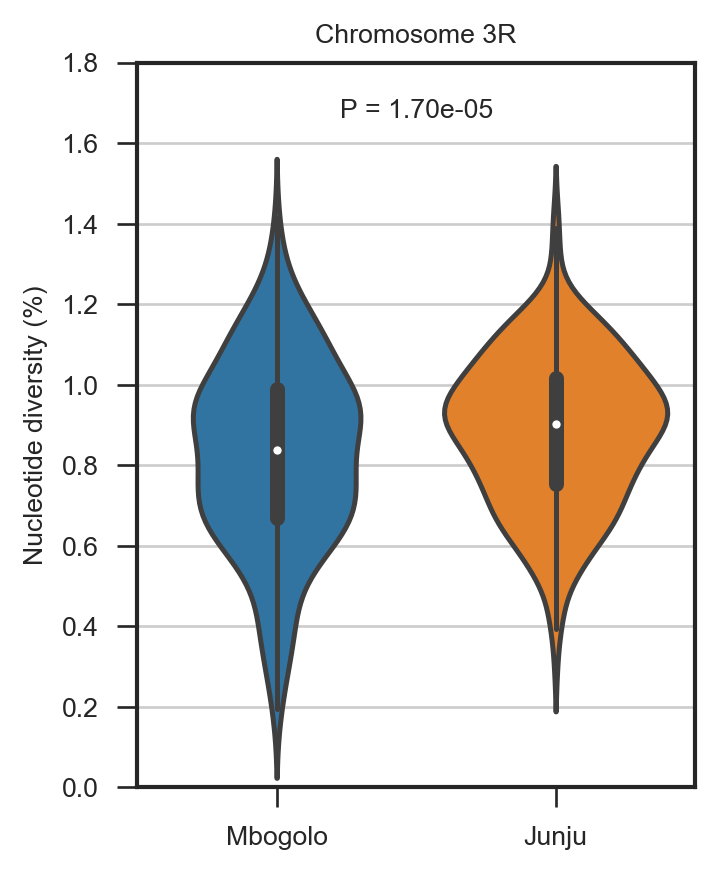

In [12]:
plot_pi_comparison('3R', window_size=100000, downsample=13, seed=2)

Mbogolo 3R 100000 pi=0.81%, 95% CI [0.79 - 0.85]
Junju 3R 100000 pi=0.90%, 95% CI [0.87 - 0.93]
Wilcoxon P=4.07e-04


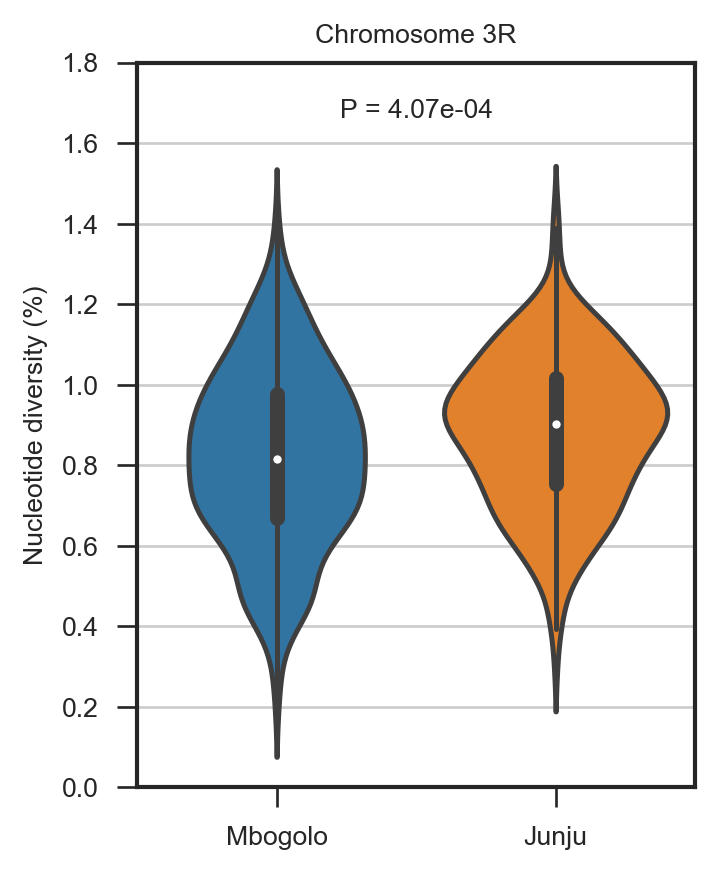

In [13]:
plot_pi_comparison('3R', window_size=100000, downsample=13, seed=3)

In [14]:
chromosomes

('2R', '2L', '3R', '3L', 'X', 'Y_unplaced', 'UNKN')

Mbogolo 2R 100000 pi=0.83%, 95% CI [0.82 - 0.85]
Junju 2R 100000 pi=0.89%, 95% CI [0.88 - 0.90]
Wilcoxon P=2.62e-39
Mbogolo 2L 100000 pi=0.87%, 95% CI [0.84 - 0.89]
Junju 2L 100000 pi=0.91%, 95% CI [0.88 - 0.94]
Wilcoxon P=2.86e-17
Mbogolo 3R 100000 pi=0.82%, 95% CI [0.79 - 0.84]
Junju 3R 100000 pi=0.90%, 95% CI [0.87 - 0.93]
Wilcoxon P=4.97e-13
Mbogolo 3L 100000 pi=0.88%, 95% CI [0.84 - 0.91]
Junju 3L 100000 pi=0.82%, 95% CI [0.76 - 0.87]
Wilcoxon P=1.56e-07
Mbogolo X 100000 pi=0.45%, 95% CI [0.42 - 0.47]
Junju X 100000 pi=0.45%, 95% CI [0.43 - 0.48]
Wilcoxon P=0.260


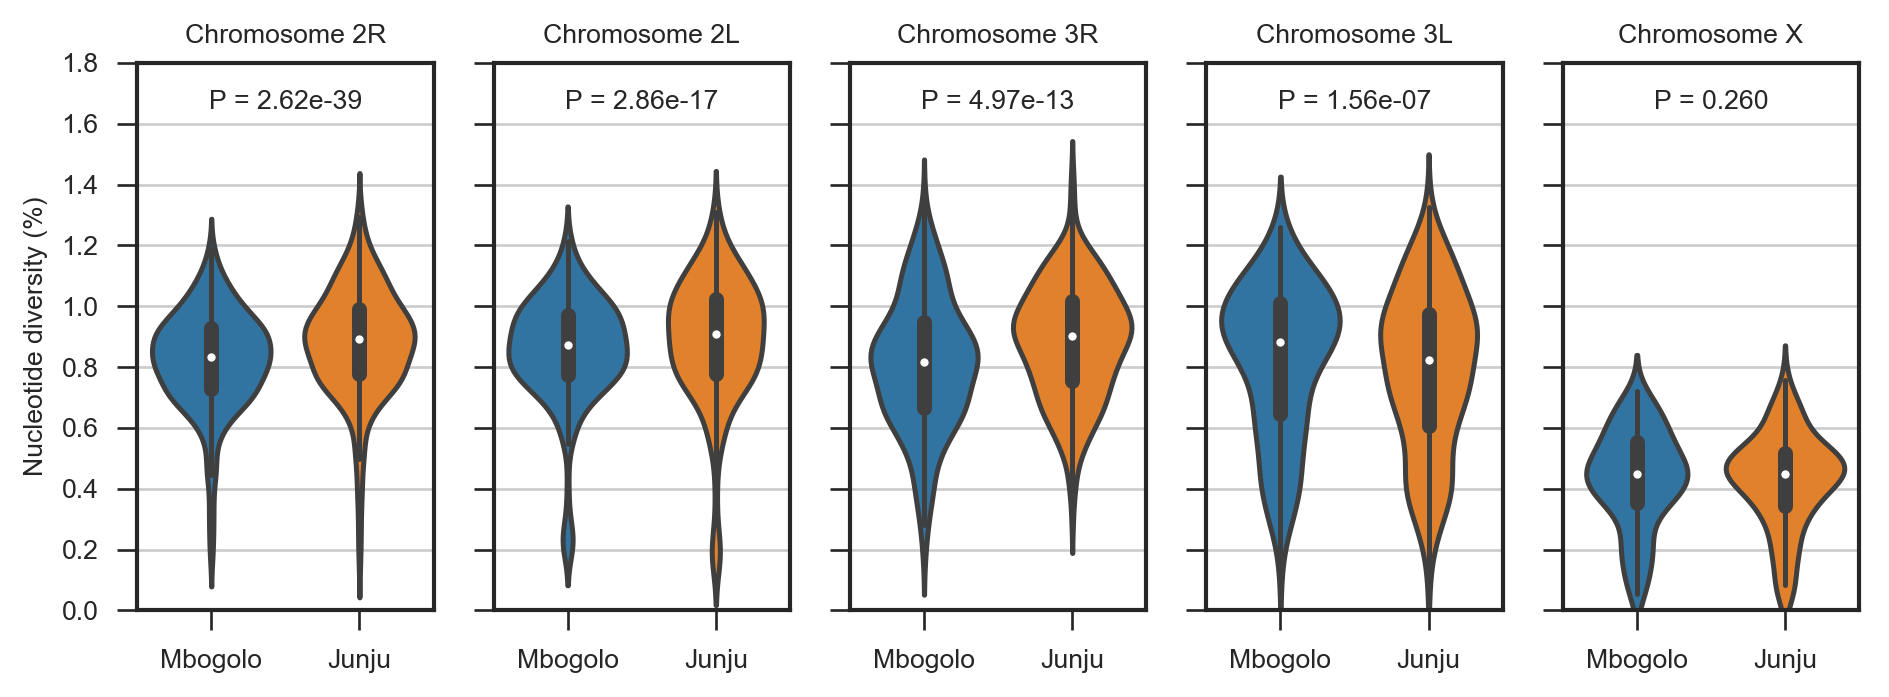

In [15]:
def fig_pi_comparison(window_size=100000):
    
    fig, axs = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(8, 3))
    
    for i, chrom in enumerate(chromosomes[:5]):
        ax = axs[i]
        plot_pi_comparison(chrom, window_size=window_size, ax=ax)
        if i > 0:
            ax.set_ylabel('')
        
    fig.tight_layout()
    fig.savefig('../artwork/pi_comparison_chroms.png', dpi=150, bbox_inches='tight')
    
fig_pi_comparison()

In [16]:
genome = phase1_ar3.genome

In [17]:
def plot_pi_genome_comparison(chrom, window_size=100000, ax=None, line_kws=None, **kwargs):
    
    windows, y1 = compute_windowed_diversity(chrom, query=query_mbogolo, window_size=window_size)
    _, y2 = compute_windowed_diversity(chrom, query=query_junju, window_size=window_size)
#     delta = y2 - y1
    x = windows.mean(axis=1)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 2))
        
    if chrom in {'2L', '3L'}:
        sns.despine(ax=ax, left=True, right=False, top=False)
    if chrom in {'2R', '3R'}:
        sns.despine(ax=ax, left=False, right=True, top=False)
        
    if not line_kws:
        line_kws = dict(lw=1.5)
    ax.plot(x, y1, label='Mbogolo', **line_kws)
    ax.plot(x, y2, label='Junju', **line_kws)
#     ax.plot(x, delta, lw=1.5)
    
    ax.grid(axis='y')
    ax.set_ylim(0, 1.5)
    yticks = np.arange(0, 1.5, 0.5)
    ax.set_yticks(yticks)
    xticks = np.arange(0, len(genome[chrom]), 1e7)
    ax.set_xticks(xticks)
    ax.set_xticklabels((xticks/1e6).astype(int))
    ax.set_xlim(0, len(genome[chrom]))
    

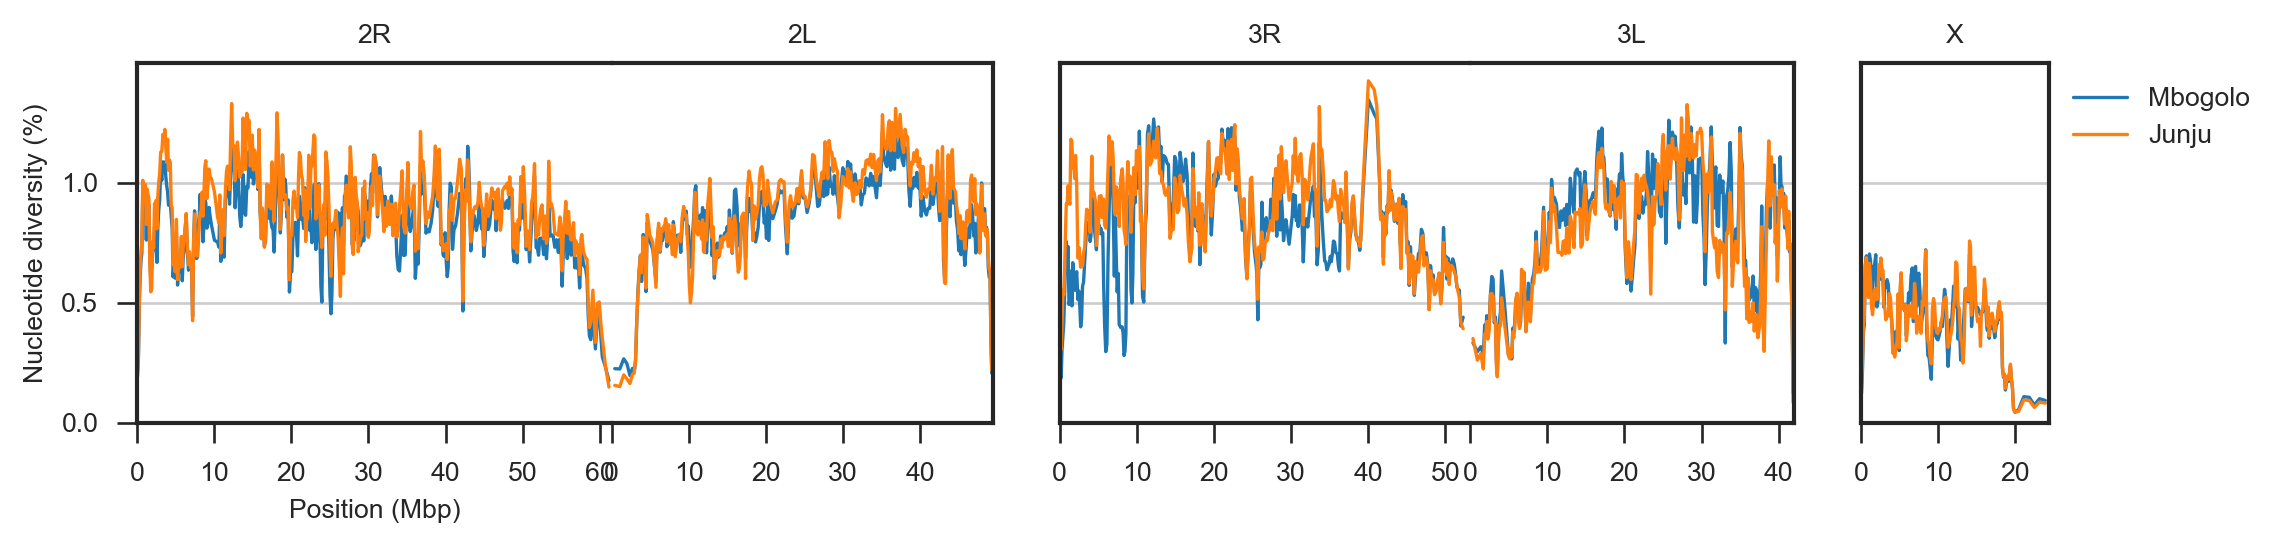

In [18]:
def fig_pi_genome_comparison(fig=None, bottom=0, height=1):

    if fig is None:
        fig = plt.figure(figsize=(8, 1.5))
    axs = fig_linear_genome(plot_pi_genome_comparison, genome=phase1_ar3.genome, fig=fig, line_kws=dict(lw=1), bottom=bottom, height=height)
    for chrom in chromosomes[:5]:
        ax = axs[chrom]
        ax.set_title(chrom)
        if chrom != '2R':
            ax.set_yticklabels([])
            ax.yaxis.set_tick_params(length=0)
    ax = axs['2R']
    ax.set_ylabel('Nucleotide diversity (%)')
    ax.set_xlabel('Position (Mbp)')
    ax = axs['X']
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.savefig('../artwork/pi_genome_comparison.png', dpi=150, bbox_inches='tight')
    return axs
                
            
fig_pi_genome_comparison();

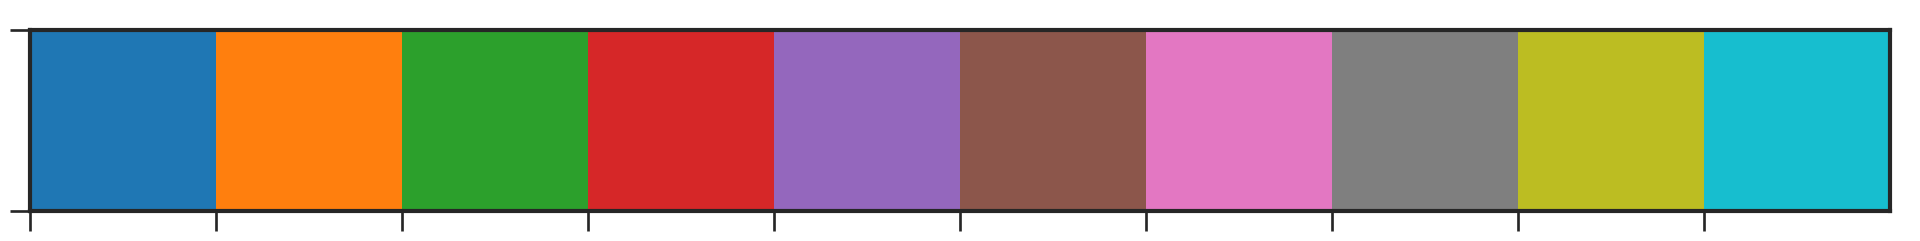

In [19]:
palette = sns.color_palette()
sns.palplot(palette);

In [20]:
def plot_pi_genome_delta(chrom, window_size=100000, ax=None, line_kws=None, **kwargs):
    
    windows, y1 = compute_windowed_diversity(chrom, query=query_mbogolo, window_size=window_size)
    _, y2 = compute_windowed_diversity(chrom, query=query_junju, window_size=window_size)
    delta = y2 - y1
    x = windows.mean(axis=1)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 2))
        
    if chrom in {'2L', '3L'}:
        sns.despine(ax=ax, left=True, right=False, top=False)
    if chrom in {'2R', '3R'}:
        sns.despine(ax=ax, left=False, right=True, top=False)
        
    if not line_kws:
        line_kws = dict(lw=1)
    ax.plot(x, delta, color='k', **line_kws)
    loc = delta > 0
    ax.fill_between(x, delta, where=delta>0, color=palette[1])
    ax.fill_between(x, delta, where=delta<0, color=palette[0])
    ax.axhline(linestyle='--', color='k')
#     ax.plot(x, delta, lw=1.5)
    
    ax.grid(axis='y')
    ax.set_ylim(-.8, .8)
    xticks = np.arange(0, len(genome[chrom]), 1e7)
    ax.set_xticks(xticks)
    ax.set_xticklabels((xticks/1e6).astype(int))
    ax.set_xlim(0, len(genome[chrom]))
    

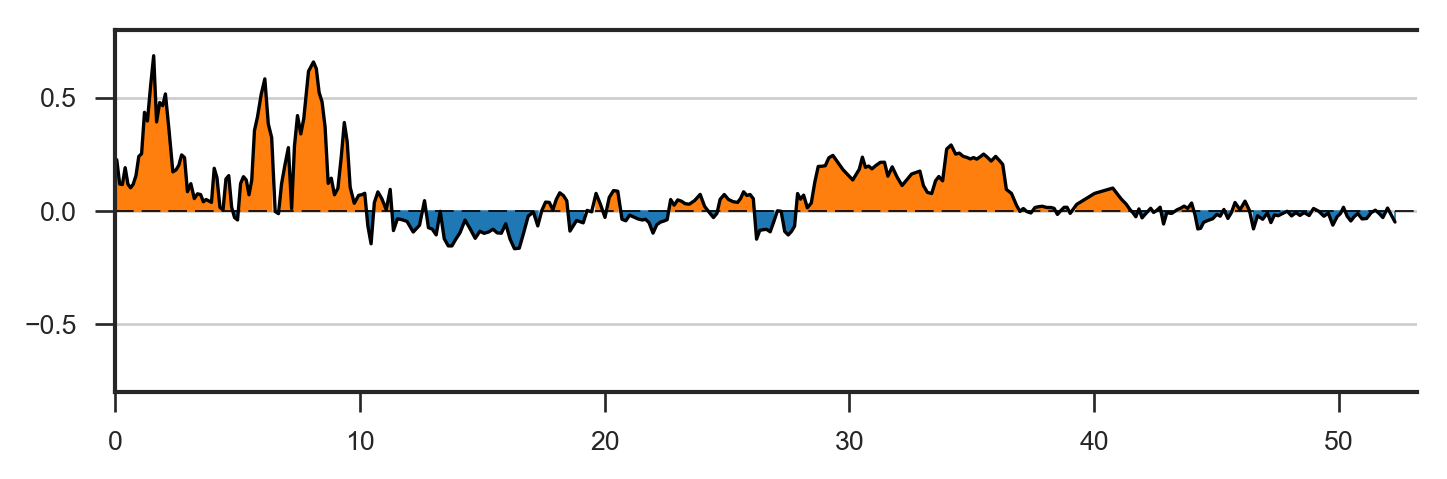

In [21]:
plot_pi_genome_delta('3R')

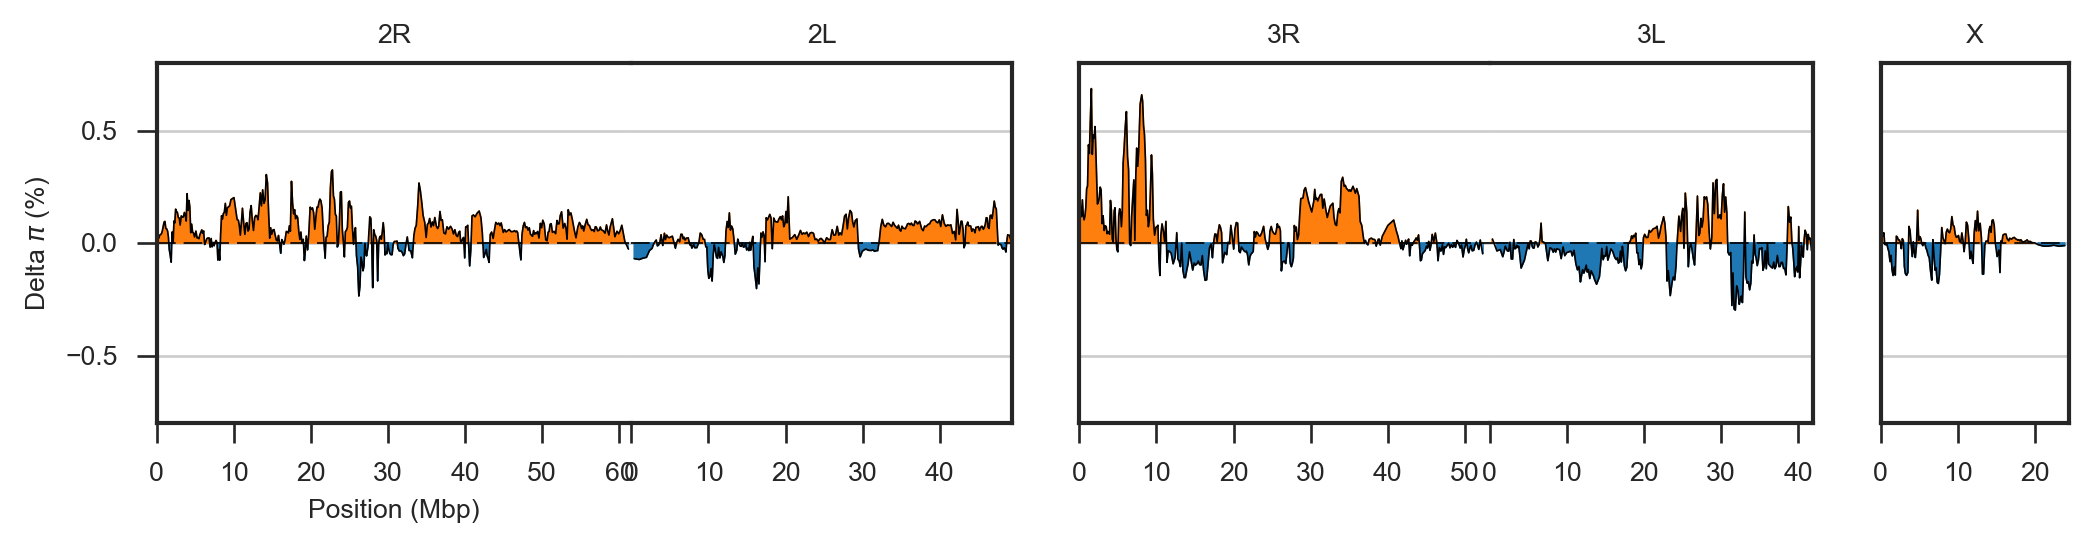

In [22]:
def fig_pi_genome_delta(fig=None, bottom=0, height=1):

    if fig is None:
        fig = plt.figure(figsize=(8, 1.5))
    axs = fig_linear_genome(plot_pi_genome_delta, genome=phase1_ar3.genome, fig=fig, line_kws=dict(lw=.5), bottom=bottom, height=height)
    for chrom in chromosomes[:5]:
        ax = axs[chrom]
        ax.set_title(chrom)
        if chrom != '2R':
            ax.set_yticklabels([])
            ax.yaxis.set_tick_params(length=0)
    ax = axs['2R']
    ax.set_ylabel('Delta $\pi$ (%)')
    ax.set_xlabel('Position (Mbp)')
    ax = axs['X']
    fig.savefig('../artwork/pi_genome_delta.png', dpi=150, bbox_inches='tight')
    return axs
                
            
fig_pi_genome_delta();

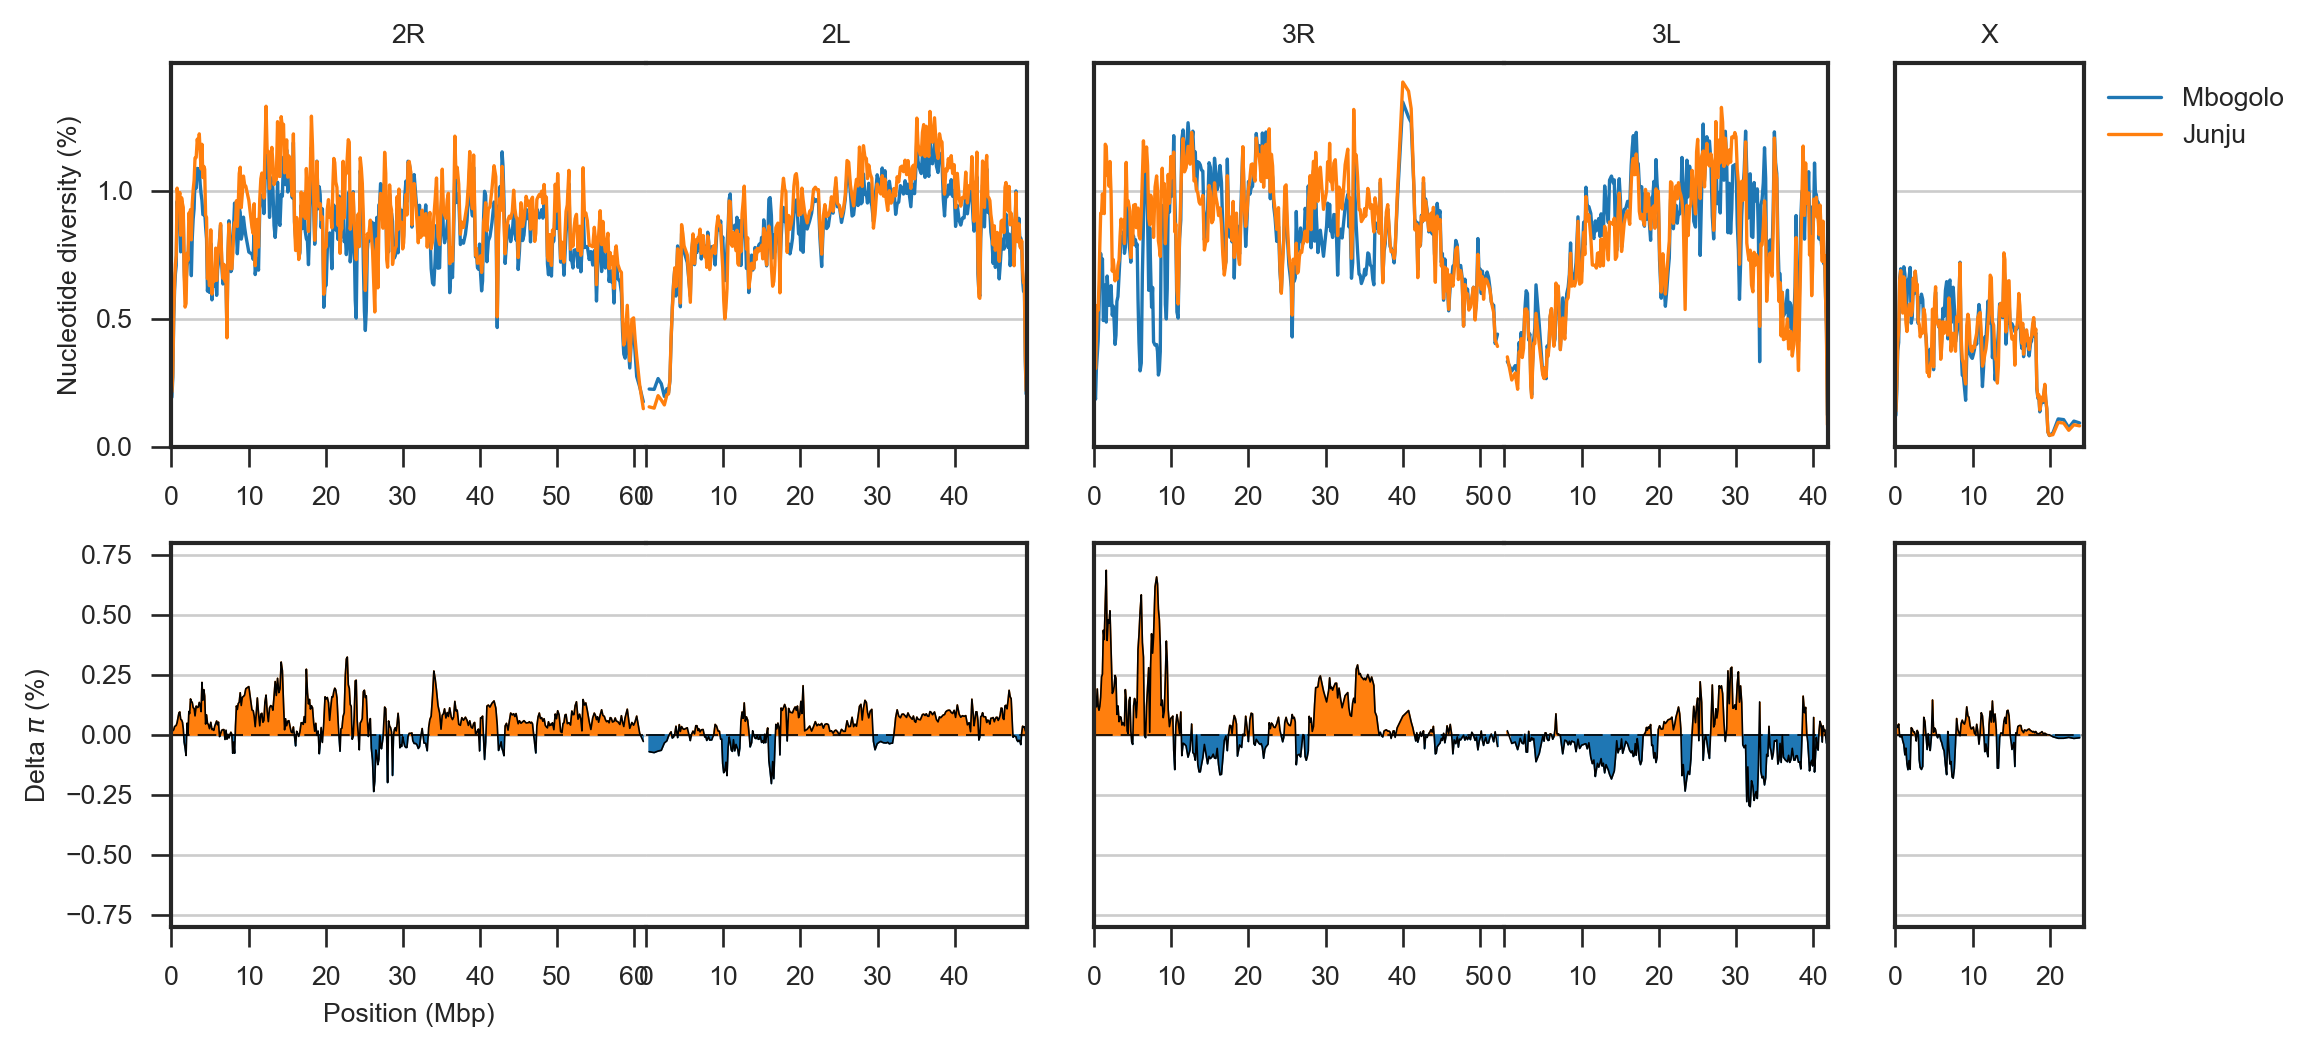

In [23]:
def fig_pi_genome_combined():
    
    fig = plt.figure(figsize=(8, 4))
    axs = fig_pi_genome_comparison(fig=fig, bottom=.5, height=.4)
    axs['2R'].set_xlabel('')
    axs = fig_pi_genome_delta(fig=fig, bottom=0, height=.4)
    for ax in axs.values():
        ax.set_title('')
    fig.savefig('../artwork/pi_genome_combined.png', dpi=150, bbox_inches='tight')

fig_pi_genome_combined()